# 06. 아이템 기반 최근접 이웃 협업 필터링 실습

## 데이터 가공 및 변환

In [1]:
import pandas as pd
import numpy as np

movies = pd.read_csv('/content/sample_data/movies.csv')
ratings = pd.read_csv('/content/sample_data/ratings.csv')
print(movies.shape)
print(ratings.shape)

(9742, 3)
(100836, 4)


movies 데이터
- 영화 title, genres

ratings 데이터
- 사용자별 영화에 대한 평점 데이터
- 0.5~5 0.5점 단위 평점

In [2]:
# pivot_table()을 이용해 위와 같은 변환 수행
ratings = ratings[['userId', 'movieId', 'rating']]
ratings_matrix = ratings.pivot_table('rating', index='userId', columns='movieId')
ratings_matrix.head(3)

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,NaN,4.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
# title 칼럼을 얻기 위해 movies와 조인
rating_movies = pd.merge(ratings, movies, on='movieId')

# columns='title'로 title 칼럼으로 피벗 수행
ratings_matrix = rating_movies.pivot_table('rating', index='userId', columns='title')

# NaN 값을 모두 0으로 변환
ratings_matrix = ratings_matrix.fillna(0)
ratings_matrix.head(3)

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 영화 간 유사도 산출

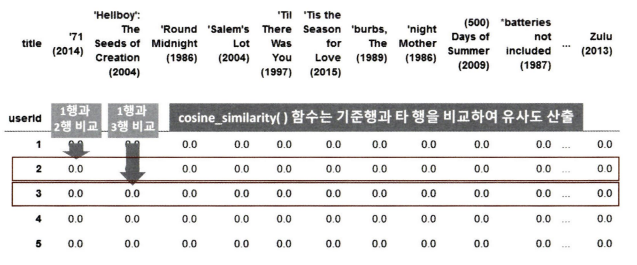

In [4]:
# 전치행렬 생성
ratings_matrix_T = ratings_matrix.transpose()
ratings_matrix_T.head(3)

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
title,,,,,,,,,,,,,,,,,,,,,
'71 (2014),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
'Hellboy': The Seeds of Creation (2004),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
'Round Midnight (1986),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
from sklearn.metrics.pairwise import cosine_similarity

item_sim = cosine_similarity(ratings_matrix_T, ratings_matrix_T)

# cosine_similarity()로 반환된 넘파이 행렬을 영화명을 매핑해 DF로 변환
item_sim_df = pd.DataFrame(data=item_sim, index=ratings_matrix.columns, columns = ratings_matrix.columns)
print(item_sim_df.shape)
item_sim_df.head(3)

(9719, 9719)


title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
title,,,,,,,,,,,,,,,,,,,,,
'71 (2014),1.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.141653,0.0,...,0.0,0.342055,0.543305,0.707107,0.0,0.0,0.139431,0.327327,0.0,0.0
'Hellboy': The Seeds of Creation (2004),0.0,1.000000,0.707107,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0
'Round Midnight (1986),0.0,0.707107,1.000000,0.0,0.0,0.0,0.176777,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0


In [6]:
# 대부와 유사도가 높은 상위 6개 영화 추출
item_sim_df["Godfather, The (1972)"].sort_values(ascending=False)[:6]

title
Godfather, The (1972)                        1.000000
Godfather: Part II, The (1974)               0.821773
Goodfellas (1990)                            0.664841
One Flew Over the Cuckoo's Nest (1975)       0.620536
Star Wars: Episode IV - A New Hope (1977)    0.595317
Fargo (1996)                                 0.588614
Name: Godfather, The (1972), dtype: float64

In [7]:
# 인셉션과 유사도가 높은 상위 6개 영화 추출
item_sim_df["Inception (2010)"].sort_values(ascending=False)[1:6]

title
Dark Knight, The (2008)          0.727263
Inglourious Basterds (2009)      0.646103
Shutter Island (2010)            0.617736
Dark Knight Rises, The (2012)    0.617504
Fight Club (1999)                0.615417
Name: Inception (2010), dtype: float64

## 아이템 기반 최근접 이웃 협업 필터링으로 개인화된 영화 추천

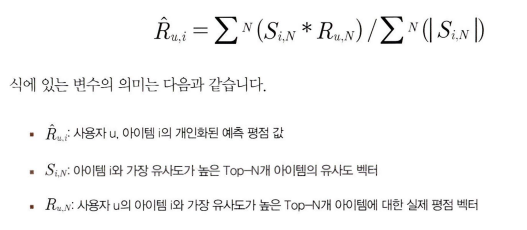

In [8]:
def predict_rating(ratings_arr, item_sim_arr):
    ratings_pred = ratings_arr.dot(item_sim_arr)/ np.array([np.abs(item_sim_arr).sum(axis=1)])
    return ratings_pred

In [9]:
# 개인화된 예측 평점 구하기
ratings_pred = predict_rating(ratings_matrix.values, item_sim_df.values)
ratings_pred_matrix = pd.DataFrame(data=ratings_pred, index= ratings_matrix.index,
                                   columns = ratings_matrix.columns)
ratings_pred_matrix.head(3)

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,0.070345,0.577855,0.321696,0.227055,0.206958,0.194615,0.249883,0.102542,0.157084,0.178197,...,0.113608,0.181738,0.133962,0.128574,0.006179,0.212070,0.192921,0.136024,0.292955,0.720347
2,0.018260,0.042744,0.018861,0.000000,0.000000,0.035995,0.013413,0.002314,0.032213,0.014863,...,0.015640,0.020855,0.020119,0.015745,0.049983,0.014876,0.021616,0.024528,0.017563,0.000000
3,0.011884,0.030279,0.064437,0.003762,0.003749,0.002722,0.014625,0.002085,0.005666,0.006272,...,0.006923,0.011665,0.011800,0.012225,0.000000,0.008194,0.007017,0.009229,0.010420,0.084501


- 예측 평점이 사용자별 영화의 실제 평점과 영화의 코사인 유사도를 내적한 값이기 때문에 기존에 영화를 관람하지 않아 0에 해당했던 실제 영화 평점이 예측에서는 값이 부여되는 경우가 많이 발생해 예측 평점이 실제 평점에 비해 작을 수 있음

In [10]:
# MSE를 구하는 함수

from sklearn.metrics import mean_squared_error

# 사용자가 평점을 부여한 영화에 대해서만 예측 성능 평가 MSE 를 구함.
def get_mse(pred, actual):
    # Ignore nonzero terms.
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return mean_squared_error(pred, actual)

print('아이템 기반 모든 인접 이웃 MSE: ', get_mse(ratings_pred, ratings_matrix.values ))

아이템 기반 모든 인접 이웃 MSE:  9.895354759094706


In [11]:
def predict_rating_topsim(ratings_arr, item_sim_arr, n=20):
    # 사용자-아이템 평점 행렬 크기만큼 0으로 채운 예측 행렬 초기화
    pred = np.zeros(ratings_arr.shape)

    # 사용자-아이템 평점 행렬의 열 크기만큼 Loop 수행.
    for col in range(ratings_arr.shape[1]):
        # 유사도 행렬에서 유사도가 큰 순으로 n개 데이터 행렬의 index 반환
        top_n_items = [np.argsort(item_sim_arr[:, col])[:-n-1:-1]]
        # 개인화된 예측 평점을 계산
        for row in range(ratings_arr.shape[0]):
            pred[row, col] = item_sim_arr[col, :][top_n_items].dot(ratings_arr[row, :][top_n_items].T)
            pred[row, col] /= np.sum(np.abs(item_sim_arr[col, :][top_n_items]))
    return pred

In [12]:
ratings_pred = predict_rating_topsim(ratings_matrix.values , item_sim_df.values, n=20)
print('아이템 기반 인접 TOP-20 이웃 MSE: ', get_mse(ratings_pred, ratings_matrix.values ))

# 계산된 예측 평점 데이터는 DataFrame으로 재생성
ratings_pred_matrix = pd.DataFrame(data=ratings_pred, index= ratings_matrix.index,
                                   columns = ratings_matrix.columns)

아이템 기반 인접 TOP-20 이웃 MSE:  3.6949827608772314


In [13]:
# 9번 아이디 사용자가 평점을 준 영화를 평점이 높은 순으로 나열
user_rating_id = ratings_matrix.loc[9, :]
user_rating_id[ user_rating_id > 0].sort_values(ascending=False)[:10]

title
Adaptation (2002)                                                                 5.0
Citizen Kane (1941)                                                               5.0
Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)    5.0
Producers, The (1968)                                                             5.0
Lord of the Rings: The Two Towers, The (2002)                                     5.0
Lord of the Rings: The Fellowship of the Ring, The (2001)                         5.0
Back to the Future (1985)                                                         5.0
Austin Powers in Goldmember (2002)                                                5.0
Minority Report (2002)                                                            4.0
Witness (1985)                                                                    4.0
Name: 9, dtype: float64

In [14]:
# 평점을 주지 않은 영화를 리스트 객체로 변환하는 함수
def get_unseen_movies(ratings_matrix, userId):
    # userId로 입력받은 사용자의 모든 영화정보 추출하여 Series로 반환함.
    # 반환된 user_rating 은 영화명(title)을 index로 가지는 Series 객체임.
    user_rating = ratings_matrix.loc[userId,:]

    # user_rating이 0보다 크면 기존에 관람한 영화임. 대상 index를 추출하여 list 객체로 만듬
    already_seen = user_rating[ user_rating > 0].index.tolist()

    # 모든 영화명을 list 객체로 만듬.
    movies_list = ratings_matrix.columns.tolist()

    # list comprehension으로 already_seen에 해당하는 movie는 movies_list에서 제외함.
    unseen_list = [ movie for movie in movies_list if movie not in already_seen]

    return unseen_list

In [15]:
def recomm_movie_by_userid(pred_df, userId, unseen_list, top_n=10):
    # 예측 평점 DataFrame에서 사용자id index와 unseen_list로 들어온 영화명 컬럼을 추출하여
    # 가장 예측 평점이 높은 순으로 정렬함.
    recomm_movies = pred_df.loc[userId, unseen_list].sort_values(ascending=False)[:top_n]
    return recomm_movies

# 사용자가 관람하지 않는 영화명 추출
unseen_list = get_unseen_movies(ratings_matrix, 9)

# 아이템 기반의 인접 이웃 협업 필터링으로 영화 추천
recomm_movies = recomm_movie_by_userid(ratings_pred_matrix, 9, unseen_list, top_n=10)

# 평점 데이타를 DataFrame으로 생성.
recomm_movies = pd.DataFrame(data=recomm_movies.values,index=recomm_movies.index, columns=['pred_score'])
recomm_movies

,pred_score
title,
Shrek (2001),0.866202
Spider-Man (2002),0.857854
"Last Samurai, The (2003)",0.817473
Indiana Jones and the Temple of Doom (1984),0.816626
"Matrix Reloaded, The (2003)",0.800990
Harry Potter and the Sorcerer's Stone (a.k.a. Harry Potter and the Philosopher's Stone) (2001),0.765159
Gladiator (2000),0.740956
"Matrix, The (1999)",0.732693
Pirates of the Caribbean: The Curse of the Black Pearl (2003),0.689591


# 07. 행렬 분해를 이용한 잠재 요인 협업 필터링 실습

In [16]:
import numpy as np
from sklearn.metrics import mean_squared_error
from tqdm import tqdm_notebook

def get_rmse(R, P, Q, non_zeros):
    error = 0
    # 두개의 분해된 행렬 P와 Q.T의 내적 곱으로 예측 R 행렬 생성
    full_pred_matrix = np.dot(P, Q.T)

    # 실제 R 행렬에서 널이 아닌 값의 위치 인덱스 추출하여 실제 R 행렬과 예측 행렬의 RMSE 추출
    x_non_zero_ind = [non_zero[0] for non_zero in non_zeros]
    y_non_zero_ind = [non_zero[1] for non_zero in non_zeros]
    R_non_zeros = R[x_non_zero_ind, y_non_zero_ind]

    full_pred_matrix_non_zeros = full_pred_matrix[x_non_zero_ind, y_non_zero_ind]

    mse = mean_squared_error(R_non_zeros, full_pred_matrix_non_zeros)
    rmse = np.sqrt(mse)

    return rmse

In [17]:
def matrix_factorization(R, K, steps=200, learning_rate=0.01, r_lambda = 0.01):
    num_users, num_items = R.shape
    # P와 Q 매트릭스의 크기를 지정하고 정규분포를 가진 랜덤한 값으로 입력합니다.
    np.random.seed(1)
    P = np.random.normal(scale=1./K, size=(num_users, K))
    Q = np.random.normal(scale=1./K, size=(num_items, K))

    break_count = 0

    # R > 0 인 행 위치, 열 위치, 값을 non_zeros 리스트 객체에 저장.
    non_zeros = [ (i, j, R[i,j]) for i in range(num_users) for j in range(num_items) if R[i,j] > 0 ]

    # P와 Q 매트릭스를 계속 업데이트(확률적 경사하강법)
    for step in tqdm_notebook(range(steps)):
        for i, j, r in non_zeros:
            # 실제 값과 예측 값의 차이인 오류 값 구함
            eij = r - np.dot(P[i, :], Q[j, :].T)

            # Regularization을 반영한 SGD 업데이트 공식 적용
            P[i,:] = P[i,:] + learning_rate*(eij * Q[j, :] - r_lambda*P[i,:])
            Q[j,:] = Q[j,:] + learning_rate*(eij * P[i, :] - r_lambda*Q[j,:])

        rmse = get_rmse(R, P, Q, non_zeros)
        if (step % 10) == 0 :
            print("### iteration step : ", step," rmse : ", rmse)

    return P, Q

In [19]:
# 영화 평점 행렬 데이터를 새롭게 DF로 로딩한 뒤에 다시 사용자 - 아이템 평점 행렬로 만들기

import pandas as pd
import numpy as np

movies = pd.read_csv('/content/sample_data/movies.csv')
ratings = pd.read_csv('/content/sample_data/ratings.csv')

ratings = ratings[['userId', 'movieId', 'rating']]
ratings_matrix = ratings.pivot_table('rating', index='userId', columns='movieId')

# title 컬럼을 얻기 이해 movies 와 조인 수행
rating_movies = pd.merge(ratings, movies, on='movieId')

# columns='title' 로 title 컬럼으로 pivot 수행.
ratings_matrix = rating_movies.pivot_table('rating', index='userId', columns='title')

In [20]:
# 행렬 분해
P, Q = matrix_factorization(ratings_matrix.values, K=50, steps=200, learning_rate=0.01, r_lambda = 0.01)
pred_matrix = np.dot(P, Q.T)

<ipython-input-17-0d76bcd8dc0a>:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for step in tqdm_notebook(range(steps)):


  0%|          | 0/200 [00:00<?, ?it/s]

### iteration step :  0  rmse :  2.9023619751336867
### iteration step :  10  rmse :  0.7335768591017927
### iteration step :  20  rmse :  0.5115539026853442
### iteration step :  30  rmse :  0.37261628282537446
### iteration step :  40  rmse :  0.2960818299181014
### iteration step :  50  rmse :  0.2520353192341642
### iteration step :  60  rmse :  0.22487503275269854
### iteration step :  70  rmse :  0.2068545530233154
### iteration step :  80  rmse :  0.19413418783028685
### iteration step :  90  rmse :  0.18470082002720406
### iteration step :  100  rmse :  0.17742927527209104
### iteration step :  110  rmse :  0.1716522696470749
### iteration step :  120  rmse :  0.16695181946871726
### iteration step :  130  rmse :  0.16305292191997542
### iteration step :  140  rmse :  0.15976691929679646
### iteration step :  150  rmse :  0.1569598699945732
### iteration step :  160  rmse :  0.15453398186715425
### iteration step :  170  rmse :  0.15241618551077643
### iteration step :  180  rm

In [21]:
# 영화 타이틀을 칼럼명으로 가지는 DF로 변경
ratings_pred_matrix = pd.DataFrame(data=pred_matrix, index= ratings_matrix.index,
                                   columns = ratings_matrix.columns)
ratings_pred_matrix.head(3)

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,3.055084,4.092018,3.564130,4.502167,3.981215,1.271694,3.603274,2.333266,5.091749,3.972454,...,1.402608,4.208382,3.705957,2.720514,2.787331,3.475076,3.253458,2.161087,4.010495,0.859474
2,3.170119,3.657992,3.308707,4.166521,4.311890,1.275469,4.237972,1.900366,3.392859,3.647421,...,0.973811,3.528264,3.361532,2.672535,2.404456,4.232789,2.911602,1.634576,4.135735,0.725684
3,2.307073,1.658853,1.443538,2.208859,2.229486,0.780760,1.997043,0.924908,2.970700,2.551446,...,0.520354,1.709494,2.281596,1.782833,1.635173,1.323276,2.887580,1.042618,2.293890,0.396941


In [22]:
def get_unseen_movies(ratings_matrix, userId):
    # userId로 입력받은 사용자의 모든 영화정보 추출하여 Series로 반환함.
    # 반환된 user_rating 은 영화명(title)을 index로 가지는 Series 객체임.
    user_rating = ratings_matrix.loc[userId,:]

    # user_rating이 0보다 크면 기존에 관람한 영화임. 대상 index를 추출하여 list 객체로 만듬
    already_seen = user_rating[ user_rating > 0].index.tolist()

    # 모든 영화명을 list 객체로 만듬.
    movies_list = ratings_matrix.columns.tolist()

    # list comprehension으로 already_seen에 해당하는 movie는 movies_list에서 제외함.
    unseen_list = [ movie for movie in movies_list if movie not in already_seen]

    return unseen_list

In [23]:
def recomm_movie_by_userid(pred_df, userId, unseen_list, top_n=10):
    # 예측 평점 DataFrame에서 사용자id index와 unseen_list로 들어온 영화명 컬럼을 추출하여
    # 가장 예측 평점이 높은 순으로 정렬함.
    recomm_movies = pred_df.loc[userId, unseen_list].sort_values(ascending=False)[:top_n]
    return recomm_movies

In [24]:
# 사용자가 관람하지 않는 영화명 추출
unseen_list = get_unseen_movies(ratings_matrix, 9)

# 잠재 요인 협업 필터링으로 영화 추천
recomm_movies = recomm_movie_by_userid(ratings_pred_matrix, 9, unseen_list, top_n=10)

# 평점 데이타를 DataFrame으로 생성.
recomm_movies = pd.DataFrame(data=recomm_movies.values,index=recomm_movies.index,columns=['pred_score'])
recomm_movies

,pred_score
title,
Rear Window (1954),5.704612
"South Park: Bigger, Longer and Uncut (1999)",5.451100
Rounders (1998),5.298393
Blade Runner (1982),5.244951
Roger & Me (1989),5.191962
Gattaca (1997),5.183179
Ben-Hur (1959),5.130463
Rosencrantz and Guildenstern Are Dead (1990),5.087375
"Big Lebowski, The (1998)",5.038690


# 08. 파이썬 추천 시스템 패키지 - Surprise

Surprise 패키지
- 다양한 추천 알고리즘 구축
- 사이킷런의 핵심 API와 유사한 API명으로 작성되어 있음

In [25]:
! pip install scikit-surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 6.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=3163485 sha256=9b35c606891a46f8d58c8217f1ea06c2a45072288115ed5ec4366adf4e039461
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


In [28]:
# 관련 모듈 임포트
from surprise import SVD
from surprise import Dataset
from surprise import accuracy
from surprise.model_selection import train_test_split

In [29]:
# 데이터를 로딩하고 학습 데이터와 테스트 데이터 세트로 분리
data = Dataset.load_builtin('ml-100k')
# 수행 시마다 동일하게 데이터를 분할하기 위해 random_state 값 부여
trainset, testset = train_test_split(data, test_size=.25, random_state=0)

Dataset ml-100k could not be found. Do you want to download it? [Y/n] 
Trying to download dataset from https://files.grouplens.org/datasets/movielens/ml-100k.zip...
Done! Dataset ml-100k has been saved to /root/.surprise_data/ml-100k


In [30]:
# SVD로 잠재 요인 협업 필터링 수행
algo = SVD()
algo.fit(trainset)

In [31]:
# 학습된 추천 알고리즘을 기반으로 테스트 데이터 세트에 대해 추천 수행
predictions = algo.test(testset)
print('predictions type :', type(predictions), 'size :', len(predictions))
print('prediction 결과의 최초 5개 추출')
predictions[:5]

predictions type : <class 'list'> size : 25000
prediction 결과의 최초 5개 추출


[Prediction(uid='120', iid='282', r_ui=4.0, est=3.691991813467798, details={'was_impossible': False}),
 Prediction(uid='882', iid='291', r_ui=4.0, est=3.705707305506705, details={'was_impossible': False}),
 Prediction(uid='535', iid='507', r_ui=5.0, est=4.054191985450693, details={'was_impossible': False}),
 Prediction(uid='697', iid='244', r_ui=5.0, est=3.4039506443621894, details={'was_impossible': False}),
 Prediction(uid='751', iid='385', r_ui=4.0, est=3.2251276456948292, details={'was_impossible': False})]

In [32]:
[ (pred.uid, pred.iid, pred.est) for pred in predictions[:3]]

[('120', '282', 3.691991813467798),
 ('882', '291', 3.705707305506705),
 ('535', '507', 4.054191985450693)]

In [33]:
# 사용자 아이디, 아이템 아이디는 문자열로 입력해야 함
uid = str(196)
iid = str(302)
pred = algo.predict(uid, iid)
print(pred)

user: 196        item: 302        r_ui = None   est = 4.14   {'was_impossible': False}


In [34]:
# RMSE 평가 결과 확인
accuracy.rmse(predictions)

RMSE: 0.9492


0.9491839577460947

## Surprise 주요 모듈

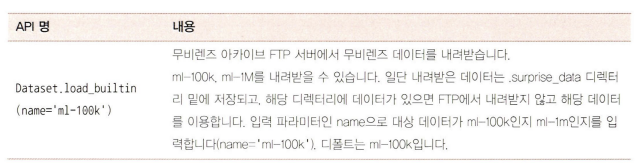

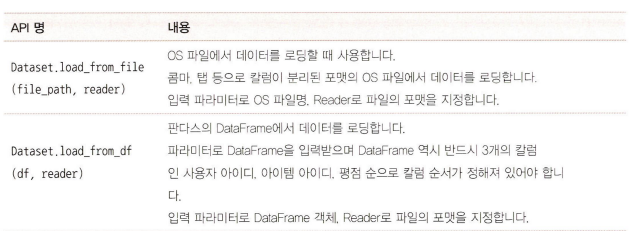

- OS 파일 데이터를 Surprise 데이터 세트로 로딩

Surprise에 OS 파일을 로딩할 때의 주의할 점
- 로딩되는 데이터 파일에 칼럼명을 가지는 헤더 문자열이 있어서는 안됨

In [36]:
import pandas as pd

ratings = pd.read_csv('/content/sample_data/ratings.csv')
# ratings_noh.csv 파일로 언로드 시 인덱스와 헤더를 모두 제거한 새로운 파일 생성
ratings.to_csv('ratings_noh.csv', index=False, header=False)

In [37]:
from surprise import Reader

reader = Reader(line_format='user item rating timestamp', sep=',', rating_scale=(0.5, 5))
data = Dataset.load_from_file('ratings_noh.csv', reader=reader)

로딩 시 ratings_noh 파일에서 앞의 3개 칼럼만 로딩되고 timestamp 칼럼은 제외됨

Reader 클래스의 주요 생성 파라미터
- line_format(string) : 칼럼을 순서대로 나열함. 입력된 문자열을 공백으로 분리해 칼럼으로 인식
- sep(char) : 칼럼을 분리하는 분리자이며, 디폴트는 '\t'임. 판다스 DF에서 입력받을 경우에는 기재할 필요 없음
- rating_scale(tuple, optional) : 평점 값의 최소~최대 평점을 설정. 디폴트는 (1,5) 이지만 ratings의 경우 최소 0.5, 최대 5이므로 (0.5,5)로 설정

In [38]:
trainset, testset = train_test_split(data, test_size=0.25, random_state=0)

# 수행 시마다 동일한 결과를 도출하기 위해 random_state 설정
algo = SVD(n_factors=50, random_state=0)

# 학습 데이터 세트로 학습하고 테스트 데이터 세트로 평점 예측 후 RMSE 평가
algo.fit(trainset)
predictions = algo.test(testset)
accuracy.rmse(predictions)

RMSE: 0.8682


0.8681952927143516

주의 : 사용자 아이디, 아이템 아이디, 평점 칼럼 순서를 지켜야함

In [39]:
import pandas as pd
from surprise import Reader, Dataset

ratings = pd.read_csv('/content/sample_data/ratings.csv')
reader = Reader(rating_scale=(0.5, 5.0))

# ratings DataFrame에서 칼럼은 사용자 아이디, 아이템 아이디, 평점 순서를 지켜야 합니다
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)
trainset, testset = train_test_split(data, test_size=0.25, random_state=0)

algo = SVD(n_factors=50, random_state=0)
algo.fit(trainset)
predictions = algo.test(testset)
accuracy.rmse(predictions)

RMSE: 0.8682


0.8681952927143516

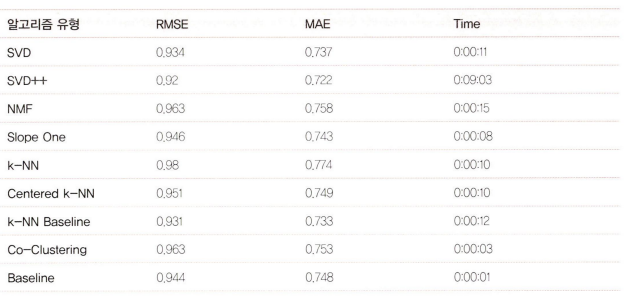

## 베이스라인 평점
계산방법

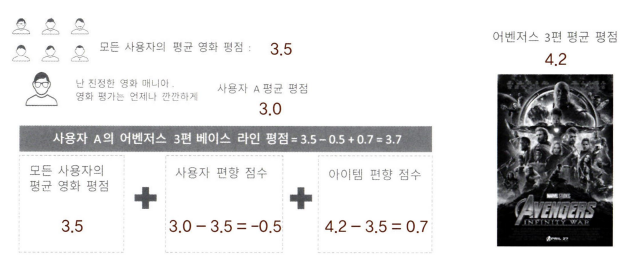

## 교차 검증과 하이퍼 파라미터 튜닝

In [40]:
from surprise.model_selection import cross_validate

# 판다스 DataFrame에서 Surprise 데이터 세트로 데이터 로딩
ratings = pd.read_csv('/content/sample_data/ratings.csv')
reader = Reader(rating_scale=(0.5, 5.0))
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

algo = SVD(random_state=0)
cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8724  0.8729  0.8735  0.8726  0.8834  0.8750  0.0042  
MAE (testset)     0.6709  0.6706  0.6680  0.6725  0.6800  0.6724  0.0041  
Fit time          2.00    1.55    1.59    2.35    3.99    2.30    0.90    
Test time         0.12    0.12    0.13    0.25    0.84    0.29    0.28    


{'test_rmse': array([0.8724035 , 0.87288946, 0.87345643, 0.87262857, 0.88337819]),
 'test_mae': array([0.67085041, 0.67056714, 0.66798929, 0.67254846, 0.6800387 ]),
 'fit_time': (2.003253698348999,
  1.5498888492584229,
  1.594679355621338,
  2.352524757385254,
  3.9938626289367676),
 'test_time': (0.12441730499267578,
  0.11695671081542969,
  0.12628412246704102,
  0.2529280185699463,
  0.8394885063171387)}

cross_validate()는 위의 출력 결과와 같이 폴드별 성능 평가 수치와 전체 폴드의 평균 성능 평가 수치를 함께 보여줌

In [41]:
from surprise.model_selection import GridSearchCV

# 최적화할 파라미터를 딕셔너리 형태로 지정
param_grid = {'n_epochs':[20, 40, 60],
            'n_factors':[50, 100, 200]}

# CV를 3개 폴드 세트로 지정, 성능 평가를 rmse, mse로 수행하도록 GridSearchCV 구성
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)
gs.fit(data)

# 최고 RMSE evaluation 점수와 그때의 하이퍼 파라미터
print(gs.best_score['rmse'])
print(gs.best_params['rmse'])

0.8783763629335608
{'n_epochs': 20, 'n_factors': 50}


## Surprise를 이용한 개인화 영화 추천 시스템 구축

In [42]:
# 분리하지 않고 데이터 사용시 오류

#data=Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)
#algo=SVD(n_factors=50, random_state=0)
#algo.fit(data)

In [43]:
from surprise.dataset import DatasetAutoFolds

reader = Reader(line_format='user item rating timestamp', sep=',', rating_scale=(0.5, 5))
# DatasetAutoFolds 클래스를 ratings_noh.csv 파일 기반으로 생성
data_folds = DatasetAutoFolds(ratings_file='ratings_noh.csv', reader=reader)

# 전체 데이터를 학습 데이터로 생성함
trainset = data_folds.build_full_trainset()

In [44]:
# SVD를 이용해 학습 수행
algo = SVD(n_epochs=20, n_factors=50, random_state=0)
algo.fit(trainset)

In [46]:
# 영화에 대한 상세 속성 정보 DataFrame 로딩
movies = pd.read_csv('/content/sample_data/movies.csv')

# userId=9의 movieId 데이터를 추출해 movieId=42 데이터가 있는지 확인
movieIds = ratings[ratings['userId']==9]['movieId']

if movieIds[movieIds==42].count()==0:
  print('사용자 아이디 9는 영화 아이디 42의 평점 없음')

print(movies[movies['movieId']==42])

사용자 아이디 9는 영화 아이디 42의 평점 없음
    movieId                   title              genres
38       42  Dead Presidents (1995)  Action|Crime|Drama


In [47]:
uid = str(9)
iid = str(42)

pred = algo.predict(uid, iid, verbose=True)

user: 9          item: 42         r_ui = None   est = 3.13   {'was_impossible': False}


In [48]:
# 사용자가 평점을 매기지 않은 전체 영화를 추출한 뒤 예측 평점 순으로 영화 추천
def get_unseen_surprise(ratings, movies, userId):
  # 입력값으로 들어온 userId에 해당하는 사용자가 평점을 매긴 모든 영화를 리스트로 생성
  seen_movies = ratings[ratings['userId']==userId]['movieId'].tolist()

  # 모든 영화의 movieId를 리스트로 생성
  total_movies = movies['movieId'].tolist()

  # 모든 영화의 movieId 중 이미 평점을 매긴 영화의 movieId를 제외한 후 리스트로 생성
  unseen_movies = [movie for movie in total_movies if movie not in seen_movies]
  print('평점 매긴 영화 수:', len(seen_movies), '추천 대상 영화 수:', len(unseen_movies), '전체 영화 수:', len(total_movies))

  return unseen_movies

unseen_movies = get_unseen_surprise(ratings, movies, 9)

평점 매긴 영화 수: 46 추천 대상 영화 수: 9696 전체 영화 수: 9742


사용자 아이디 9번은 전체 9742개의 영화 중에서 46개만 평점을 매김 -> 추천 대상 영화는 9696개

In [49]:
# SVD를 이용해 높은 예측 평점을 가진 순으로 영화 추천

def recomm_movie_by_surprise(algo, userId, unseen_movies, top_n=10):
  # 알고리즘 객체의 predict() 메서드를 평점이 없는 영화에 반복 수행한 후 결과를 list로 저장
  predictions = [algo.predict(str(userId), str(movieId)) for movieId in unseen_movies]

  # predictions list 객체는 surprise의 predictions 객체를 원소로 갖고 있음
  # [Prediction(uid='9', iid='1', est=3.69), Predictions(uid='9', iid='2', est=2.98),,,]

  # 이를 est 값으로 정렬하기 위해 아리애 sortkey_est 함수 정의함
  # sortdey_est 함수는 list 객체의 sort() 함수의 키 값으로 사용되어 정렬 수행
  def sortkey_est(pred):
    return pred.est

  # sortkey_est() 반환값의 내림차순으로 정렬 수행하고 top_n개의 최상위 값 추출
  predictions.sort(key=sortkey_est, reverse=True)
  top_predictions = predictions[:top_n]

  # top_n 으로 추출된 영화의 정보 추출. 영화 아이디, 추천 예상 평점, 제목 추출
  top_movie_ids = [int(pred.iid) for pred in top_predictions]
  top_movie_rating = [pred.est for pred in top_predictions]
  top_movie_titles = movies[movies.movieId.isin(top_movie_ids)]['title']
  top_movie_preds = [ (id, title, rating) for id, title, rating in zip(top_movie_ids, top_movie_titles, top_movie_rating)]

  return top_movie_preds

unseen_movies = get_unseen_surprise(ratings, movies, 9)
top_movie_preds = recomm_movie_by_surprise(algo, 9, unseen_movies, top_n=10)

print('### top-10 추천 영화 리스트 ###')
for top_movie in top_movie_preds:
  print(top_movie[1], ':', top_movie[2])

평점 매긴 영화 수: 46 추천 대상 영화 수: 9696 전체 영화 수: 9742
### top-10 추천 영화 리스트 ###
Usual Suspects, The (1995) : 4.306302135700814
Star Wars: Episode IV - A New Hope (1977) : 4.281663842987387
Pulp Fiction (1994) : 4.278152632122759
Silence of the Lambs, The (1991) : 4.226073566460876
Godfather, The (1972) : 4.1918097904381995
Streetcar Named Desire, A (1951) : 4.154746591122657
Star Wars: Episode V - The Empire Strikes Back (1980) : 4.122016128534504
Star Wars: Episode VI - Return of the Jedi (1983) : 4.108009609093436
Goodfellas (1990) : 4.083464936588478
Glory (1989) : 4.07887165526957
